In [1]:
import pandas as pd


df = pd.read_csv('train.csv')
df

,student_id,gender,age,study_hours,attendance_rate,previous_scores,parental_education,school_type,extracurricular,final_math_score
0,1001,Male,17,9.1,68.7,70.0,Bachelor’s,Private,3,86.2
1,1002,Female,17,10.5,66.6,84.8,Bachelor’s,Public,3,90.6
2,1003,Male,17,17.4,58.8,73.8,High School,Private,3,94.1
3,1004,Male,17,8.1,80.4,45.0,High School,Public,1,82.9
4,1005,Male,18,17.7,73.8,51.1,Master’s,Public,2,98.6
...,...,...,...,...,...,...,...,...,...,...
3995,4996,Female,18,11.3,71.2,43.6,High School,Public,4,78.8
3996,4997,Female,15,5.0,95.8,53.6,High School,Public,3,80.5
3997,4998,Female,16,19.6,74.9,55.6,Bachelor’s,Public,2,93.0
3998,4999,Female,15,3.9,69.9,63.2,Master’s,Private,3,70.9


In [2]:
df = pd.get_dummies(df,columns=['parental_education','school_type','gender'],drop_first=True)
df

,student_id,age,study_hours,attendance_rate,previous_scores,extracurricular,final_math_score,parental_education_High School,parental_education_Master’s,school_type_Public,gender_Male
0,1001,17,9.1,68.7,70.0,3,86.2,False,False,False,True
1,1002,17,10.5,66.6,84.8,3,90.6,False,False,True,False
2,1003,17,17.4,58.8,73.8,3,94.1,True,False,False,True
3,1004,17,8.1,80.4,45.0,1,82.9,True,False,True,True
4,1005,18,17.7,73.8,51.1,2,98.6,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
3995,4996,18,11.3,71.2,43.6,4,78.8,True,False,True,False
3996,4997,15,5.0,95.8,53.6,3,80.5,True,False,True,False
3997,4998,16,19.6,74.9,55.6,2,93.0,False,False,True,False
3998,4999,15,3.9,69.9,63.2,3,70.9,False,True,False,False


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x = df.drop(columns=['student_id','final_math_score'])
y = df['final_math_score']

In [4]:
from sklearn.model_selection import train_test_split,cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import optuna


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

numerical_cols = ['study_hours','age','attendance_rate','previous_scores','extracurricular']

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# qt = QuantileTransformer(output_distribution='normal')
# y_train = qt.fit_transform(y_train.values.reshape(-1,1)).ravel()
# --------- Optuna Hyperparameter Optimization ---------

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }

    model = XGBRegressor(**params)
    # 5-fold cross-validation for robustness
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

# --------- Train Final Model with Best Params ---------

model = XGBRegressor(**study.best_params)
model.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error

X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

y_pred = model.predict(X_test)
# y_pred = qt.inverse_transform(y_pred.reshape(-1,1)).ravel()

y_pred[y_pred>100] = 100
y_pred[y_pred<40] = 40

print(mean_squared_error(y_test,y_pred))


[I 2025-04-19 16:21:26,114] A new study created in memory with name: no-name-9a2b6f17-c75c-4a3e-b230-d3de514034aa
[I 2025-04-19 16:21:29,583] Trial 0 finished with value: 23.53579024050659 and parameters: {'n_estimators': 486, 'max_depth': 8, 'learning_rate': 0.06976297220829315, 'subsample': 0.8712996210389249, 'colsample_bytree': 0.6890078477907542, 'gamma': 1.5237876779694286, 'min_child_weight': 6}. Best is trial 0 with value: 23.53579024050659.
[I 2025-04-19 16:21:30,634] Trial 1 finished with value: 19.403707258574933 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.04255682857802213, 'subsample': 0.7993238597872164, 'colsample_bytree': 0.7708694759837915, 'gamma': 3.7413786823324067, 'min_child_weight': 6}. Best is trial 1 with value: 19.403707258574933.
[I 2025-04-19 16:21:31,481] Trial 2 finished with value: 19.569667027344728 and parameters: {'n_estimators': 441, 'max_depth': 3, 'learning_rate': 0.06281078267663276, 'subsample': 0.6994187446701847, 'co

Best hyperparameters: {'n_estimators': 262, 'max_depth': 4, 'learning_rate': 0.0313346972230392, 'subsample': 0.6598092007841853, 'colsample_bytree': 0.968772350715285, 'gamma': 4.319973373330618, 'min_child_weight': 9}
18.28314098717241


In [5]:
X_train

,age,study_hours,attendance_rate,previous_scores,extracurricular,parental_education_High School,parental_education_Master’s,school_type_Public,gender_Male
3994,0.419743,-0.692233,1.250435,1.197850,-1.434313,False,True,True,False
423,0.419743,-0.284434,-0.592335,0.707130,-0.728298,True,False,True,True
2991,-1.392912,-0.925261,0.063332,1.273795,-0.728298,False,True,False,False
1221,-1.392912,0.744774,-0.336970,-0.519670,0.683731,True,False,False,False
506,-1.392912,0.045689,-0.164426,0.905755,0.683731,True,False,True,False
...,...,...,...,...,...,...,...,...,...
1130,-0.486585,-0.400948,0.953659,0.835652,1.389746,False,False,True,False
1294,-1.392912,1.307925,-1.579286,-0.876027,-0.728298,True,False,False,False
860,-1.392912,-0.129082,1.554112,-1.483585,1.389746,False,True,True,False
3507,-0.486585,0.356393,1.022677,0.111255,-0.728298,False,True,True,True


In [6]:
df.describe()

,student_id,age,study_hours,attendance_rate,previous_scores,extracurricular,final_math_score
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3000.500000,16.514500,10.823475,75.025200,70.508950,2.022000,87.507875
std,1154.844867,1.116737,5.157597,14.553043,17.217398,1.417575,12.196231
min,1001.000000,15.000000,2.000000,50.000000,40.000000,0.000000,40.100000
25%,2000.750000,16.000000,6.400000,62.300000,55.800000,1.000000,79.300000
50%,3000.500000,17.000000,10.700000,74.700000,70.900000,2.000000,89.900000
75%,4000.250000,18.000000,15.200000,87.900000,85.100000,3.000000,100.000000
max,5000.000000,18.000000,20.000000,100.000000,100.000000,4.000000,100.000000


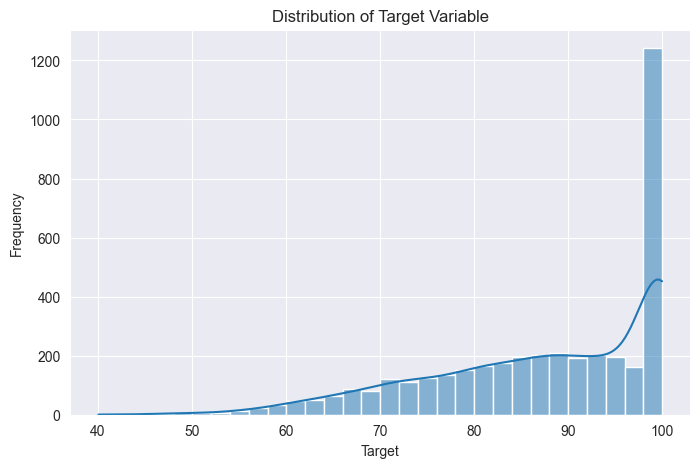

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the distribution
plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=30)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [8]:
test_df = pd.read_csv('test.csv')

test_df = pd.get_dummies(test_df, columns=['parental_education', 'school_type', 'gender'], drop_first=True)
test_df

,student_id,age,study_hours,attendance_rate,previous_scores,extracurricular,parental_education_High School,parental_education_Master’s,school_type_Public,gender_Male
0,5001,15,18.4,53.7,63.2,1,True,False,True,False
1,5002,18,11.5,54.5,52.3,2,False,True,True,True
2,5003,15,15.0,82.6,43.9,0,True,False,True,True
3,5004,16,9.8,74.3,44.8,2,True,False,False,True
4,5005,15,13.3,89.5,85.6,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
995,5996,18,17.4,82.5,92.6,3,True,False,True,True
996,5997,17,18.2,58.9,42.8,1,False,True,False,False
997,5998,16,19.0,52.6,58.2,2,False,False,True,True
998,5999,16,9.2,84.1,66.6,1,False,False,False,False


In [9]:
x_sub = test_df.drop(columns='student_id')
x_sub[numerical_cols] = scaler.transform(x_sub[numerical_cols])

sub_pred = model.predict(x_sub)
sub_pred[sub_pred > 100] = 100
sub_pred[sub_pred < 40] = 40


In [10]:
sub_pred

array([ 89.94646 ,  72.50193 ,  88.85323 ,  75.93758 ,  98.29971 ,
        88.757706,  87.79409 ,  96.9796  ,  76.77249 ,  88.671646,
        95.99332 ,  97.0644  ,  67.55186 ,  67.29893 ,  65.64223 ,
        63.782852,  69.41955 ,  87.68729 ,  79.81147 ,  79.465225,
        77.84167 , 100.      ,  86.3809  ,  88.55453 ,  89.10211 ,
        88.90151 ,  85.87537 ,  69.59464 ,  84.37048 ,  63.431187,
        94.739006,  99.74803 , 100.      ,  91.533714,  84.745285,
        97.518745,  82.06583 ,  99.15517 ,  99.19916 ,  59.312595,
        72.548065,  72.57967 ,  99.06738 ,  72.138695,  85.38125 ,
        58.40105 ,  68.07402 ,  87.72857 ,  99.59513 ,  78.91954 ,
        91.706665,  79.183975,  90.61674 ,  94.88878 ,  89.288   ,
       100.      ,  98.99504 ,  71.327095,  66.47594 ,  98.0719  ,
       100.      , 100.      , 100.      ,  85.547005,  81.32953 ,
        85.718704,  78.91487 ,  76.91718 ,  74.87461 ,  58.302376,
        93.62369 ,  92.869446,  78.806465,  94.131935,  74.718

In [11]:
sub_df = test_df[['student_id']].copy()
sub_df['final_math_score'] = sub_pred
sub_df

,student_id,final_math_score
0,5001,89.946457
1,5002,72.501930
2,5003,88.853233
3,5004,75.937576
4,5005,98.299713
...,...,...
995,5996,100.000000
996,5997,82.067589
997,5998,88.809952
998,5999,86.441544


In [12]:
sub_df.to_csv('sub.csv',index=False)